<h1><center> Hands-on Workshop: Machine Learning with Python </center></h1>
<center>Organized by the B-Phot Student Chapter the 10th of December, 2022 in Brussels</center>

<h1><center>Data Science for Raman Spectroscopy</center></h1>
<center>A practical example by Nicolás Coca-López</center>
____________________________________________________________________________________________________________________

This jupyter notebook is part of the lecture "Data Science for Raman spectroscopy" imparted by Nicolás Coca-López during the Hands-on Workshop Machine Learning with Python in Brussels, organized by the B-Phot Student Chapter the 10th of December, 2022.

## Introduction

Raman spectroscopy provides information about the vibrational modes of molecules in the form of Raman spectra. These spectra can work like a structural fingerprint by which molecules and materials can be identified and characterized. From them we can learn things like what is our material composed of, what is its temperature, where are the tension whithin the material, if there is any applied electromagnetic field, etc. However, in order to extract such information we first need to clean and process the data before applying a chemometric or machine learning model. In the present draft I will explain how the data science pipeline works on Raman spectral data and give an example chemometrics for quantitative spectral analysis. 

## An example of Data Science for Raman spectroscopy

The aim of this notebook is to show the typical workflow of analysis and modelling of Raman spectral data. For that purpose, a synthetic Raman spectrum is generated based on three distinct components. Different kinds of noise are added for the shake of reality. The most usual steps of pre-processing are applied in order to recover a clean spectrum. Finally, a classical least squares method is used to estimate the concentration of the three distinct components.

This notebook is therefore divided in three parts: <br>
1) Generation of a synthetic spectrum <br>
2) Preprocessing of the Spectrum <br>
3) Application of classical least squares to calculate the amount of different components on the spectrum



Let's start by loading the libraries that we are going to use.

In [1]:
# Loading the required packages:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter, general_gaussian
import sklearn.linear_model as linear_model

## Generation of sinthetic data

For this practical example, we are going to simulate some Raman spectra, so we know what to expect.

1) We are going to generate three components, which we will mix with a given ratio. 

2) In order to make it more real, we will add noise: Random noise, spikes and a background baseline.

### Generation of a mixture spectrum made of three components

Even this topic is much more complex, for this example, let's assume that our signal is composse of gaussian peaks. We define a gaussian function as:

In [2]:
# Gaussian function

def Gauss(x, mu, sigma, A = 1):
    # This def returns the Gaussian function of x
    # x is an array
    # mu is the expected value
    # sigma is the square root of the variance
    # A is a multiplication factor
    
    gaussian = A/(sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mu)/sigma)**2)
    
    return gaussian

We first generate the three components:

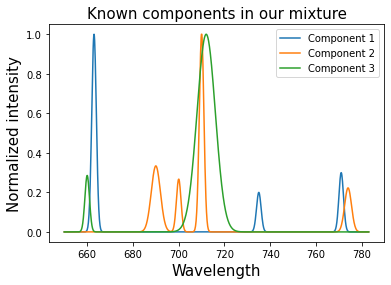

In [3]:
# X-axis (Wavelengths)
x_range =  np.linspace(650, 783, 1024)

# Let's create three different components

# Component A
mu_a1 = 663
sigma_a1 = 1
intensity_a1 = 1

mu_a2 = 735
sigma_a2 = 1
intensity_a2 = 0.2

mu_a3 = 771
sigma_a3 = 1
intensity_a3 = 0.3

gauss_a =  Gauss(x_range, mu_a1, sigma_a1, intensity_a1) + Gauss(x_range, mu_a2, sigma_a2, intensity_a2) + Gauss(x_range, mu_a3, sigma_a3, intensity_a3)

# Component B
mu_b = 700
sigma_b = 1
intensity_b = 0.2

mu_b1 = 690
sigma_b1 = 2
intensity_b1 = 0.5

mu_b2 = 710
sigma_b2 = 1
intensity_b2 = 0.75

mu_b3 = 774
sigma_b3 = 1.5
intensity_b3 = 0.25

gauss_b = Gauss(x_range, mu_b, sigma_b, intensity_b) + Gauss(x_range, mu_b1, sigma_b1, intensity_b1) + Gauss(x_range, mu_b2, sigma_b2, intensity_b2) + Gauss(x_range, mu_b3, sigma_b3, intensity_b3)

# Component C
mu_c1 = 660
sigma_c1 = 1
intensity_c1 = 0.05

mu_c2 = 712
sigma_c2 = 4
intensity_c2 = 0.7

gauss_c = Gauss(x_range, mu_c1, sigma_c1, intensity_c1) + Gauss(x_range, mu_c2, sigma_c2, intensity_c2)

# Component normalization
component_a = gauss_a/np.max(gauss_a)
component_b = gauss_b/np.max(gauss_b)
component_c = gauss_c/np.max(gauss_c)

# How do they look?
plt.plot(x_range, component_a, label = 'Component 1')
plt.plot(x_range, component_b, label = 'Component 2')
plt.plot(x_range, component_c, label = 'Component 3')
plt.title('Known components in our mixture', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Normalized intensity', fontsize = 15)
plt.legend()
plt.show()

We can then generate a mixture spectrum base on these three different components:

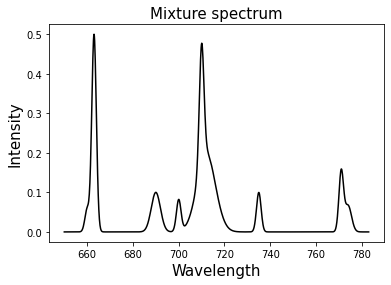

In [4]:

# What concentrations we want these components to have in our mixture:
c_a = 0.5
c_b = 0.3
c_c = 0.2

comps = np.array([c_a, c_b, c_c])

# Let's build the spectrum to be studied: The mixture spectrum
mix_spectrum = c_a * component_a + c_b * component_b + c_c *component_c

# How does it look?
plt.plot(x_range, mix_spectrum, color = 'black', label = 'Mixture spectrum with noise')
plt.title('Mixture spectrum', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.show()

In order to have a more real mixture, let's add now some noise:

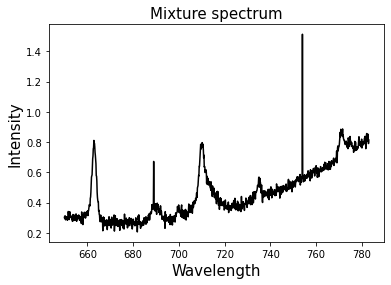

In [5]:
# Let's add some noise for a bit of realism:

# Random noise:
mix_spectrum = mix_spectrum +  np.random.normal(0, 0.02, len(x_range))

# Spikes: 
mix_spectrum[800] = mix_spectrum[800] + 1
mix_spectrum[300] = mix_spectrum[300] + 0.3

# Baseline as a polynomial background:
poly = 0.2 * np.ones(len(x_range)) + 0.0001 * x_range + 0.000051 * (x_range - 680)**2 
mix_spectrum = mix_spectrum + poly

# How does it look now?
plt.plot(x_range, mix_spectrum, color = 'black', label = 'Mixture spectrum with noise')
plt.title('Mixture spectrum', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.show()

We have now a synthetic measured spectrum.

## Pre-processing of the spectrum

Before we could do any modelling, we need to pre-process our spectrum. These are some of the things that we would do with a real meassured spectra: Clean the spikes, smooth the noise and subtract the baseline. To do so, we will use some simple algorithms as described below.

For a more complete list of Raman spectra processing steps, the reader is encoraged to go to B. Barton et al (Applied Spectroscopy 76 (9), 1021-1041) or to O. Ryabchykov et al (https://doi.org/10.1515/psr-2017-0043).

### i) Despiking the spectrum

The first step is to locate and clean the cosmic rays or spikes. For this we use a modified z-score based algorithm. The modified z-scores are calculated as

z(i) = 0.6745 (x(i)-M) / MAD

where the MAD = median(|x-M|), |…| represents the absolute value, and x are the values of the differentiated spectrum.

For more information see the references at the end of this notebook.

In [6]:
# The next function calculates the modified z-scores of a diferentiated spectrum

def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def fixer(y,ma):
    threshold = 7 # binarization threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            y_out[i] = np.mean(y[we])
    return y_out


We next apply the despiking algorithm:

In [7]:
despiked_spectrum = fixer(mix_spectrum,ma=10)

and compare with the original mix spectrum:

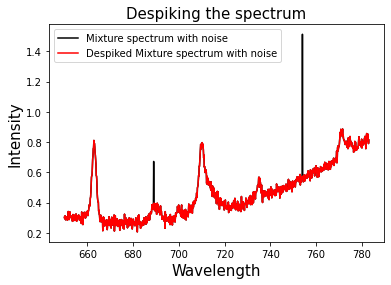

In [8]:
plt.plot(x_range, mix_spectrum, color = 'black', label = 'Mixture spectrum with noise')
plt.plot(x_range, despiked_spectrum, color = 'red', label = 'Despiked Mixture spectrum with noise')
plt.title('Despiking the spectrum', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.legend()
plt.show()

### ii) Baseline correction

In order to calculate the baseline, we use a baseline estimation algorithm based on asymetric least squares, as presented in his paper by Eilers and Boelens in 2005.

In [9]:
# Baseline stimation with asymmetric least squares
# According to paper: "Baseline Correction with Asymmetric Least Squares Smoothing" 
# by Paul H. C. Eilers and Hans F.M. Boelens. October 21, 2005

# We need the following packages here:
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Baseline stimation function:
def baseline_als(y, lam, p, niter=100):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

# For more info see the paper and https://stackoverflow.com/questions/29156532/python-baseline-correction-library

Baseline Subtraction parameters: 

As they say in their paper, "there are two parameters: **p for asymmetry** and **l for smoothness**. Both have to be tuned to the data at hand. We found that generally 0.001 < p < 0.1 is a good choice (for a signal with positive peaks) and  10^2 < l < 10^9." See Eiler and Boelens, 2005.

In [10]:
# Parameters for this case:
l = 10000000 # smoothness
p = 0.05 # asymmetry

With the help of this algorithm we can estimate the baseline and subtract it from the measured spectrum.

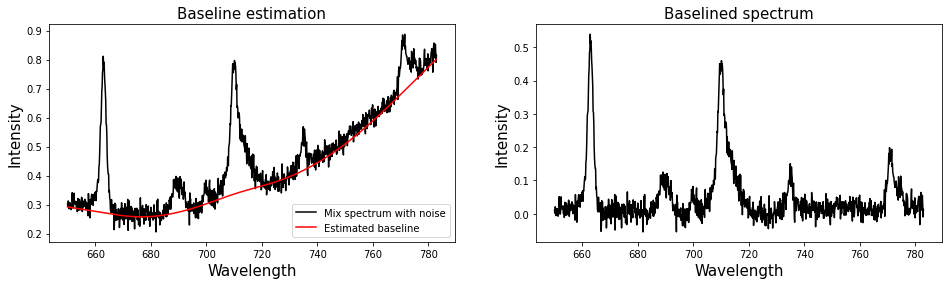

In [11]:
# Estimation of the baseline:
estimated_baselined = baseline_als(despiked_spectrum, l, p)

# Baseline subtraction:
baselined_spectrum = despiked_spectrum - estimated_baselined

# How does it look like?
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

# We compared the original mix spectrum and the estimated baseline:
ax1.plot(x_range, despiked_spectrum, color = 'black', label = 'Mix spectrum with noise' )
ax1.plot(x_range, estimated_baselined, color = 'red', label = 'Estimated baseline')
ax1.set_title('Baseline estimation', fontsize = 15)
ax1.set_xlabel('Wavelength', fontsize = 15)
ax1.set_ylabel('Intensity',  fontsize = 15)
ax1.legend()

# We plot the mix spectrum after baseline subtraction
ax2.plot(x_range, baselined_spectrum, color = 'black', label = 'Baselined spectrum with noise' )
ax2.set_title('Baselined spectrum', fontsize = 15)
ax2.set_xlabel('Wavelength', fontsize = 15)
ax2.set_ylabel('Intensity',  fontsize = 15)
plt.show()

### iii) Smoothing

In order to smooth the spectra, we use a Savitzky Golay filter as implemente in the library SciPy. The parameters window (number of points) w and polynomial order p can be optimized for every set of spectra.

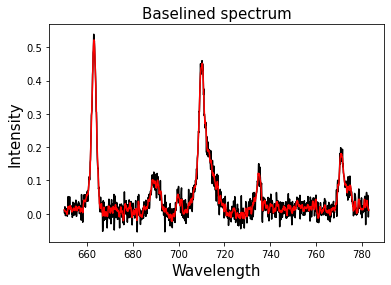

In [12]:
from scipy.signal import savgol_filter, general_gaussian

# Parameters:
w = 9 # window (number of points)
p = 2 # polynomial order

smoothed_spectrum = savgol_filter(baselined_spectrum, w, polyorder = p, deriv=0)

# Some more information on the implementation of this method can be found here:
# https://nirpyresearch.com/savitzky-golay-smoothing-method/


# We plot the mix spectrum after baseline subtraction
plt.plot(x_range, baselined_spectrum, color = 'black', label = 'Baselined spectrum with noise' )
plt.plot(x_range, smoothed_spectrum, color = 'red', label = 'Baselined spectrum with noise' )
plt.title('Baselined spectrum', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.show()

We finally have a processed spectrum to which we can apply a model. 

## Classical Least Squares Method for Quantitative Spectral Analysis

Now we have preprocessed our mix spectrum, we can apply CLS to quantify its composition.

In [13]:
query_spectrum = smoothed_spectrum # Let's just rename it

We first generate the matrix of the components K

In [14]:
# Generate the components matrix or K matrix
components = np.array([component_a, component_b, component_c])  

We can make use of Scikit-learn to implement CLS, so we import the library

In [15]:
import sklearn.linear_model as linear_model

and apply CLS to calculate the concentrations

In [16]:
cs = linear_model.LinearRegression().fit(components.T, query_spectrum).coef_
#We print the result:
print('The expected concentrations for components A, B and C are: ' + str(cs))  

The expected concentrations for components A, B and C are: [0.50307663 0.28636762 0.16477866]


Let's look at it graphically:

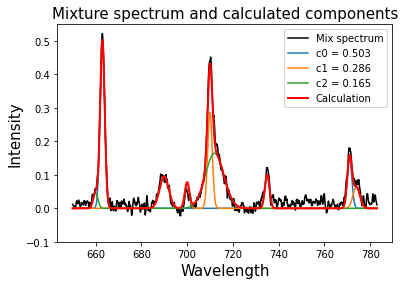

In [17]:
# Does the result match the original data?

# Plot the original data:
plt.plot(x_range, query_spectrum, color = 'black', label = 'Mix spectrum' )

# Plot the separate components times its calculated concentration:
for i in np.arange(len(cs)):
    plt.plot(x_range, cs[i]*components[i], label = 'c' + str(i)+ ' = ' + str(np.round(cs[i], 3)))

# Plot the result: the sum of separate components times its calculated concentration:
plt.plot(x_range, np.dot(cs,components), color = 'red', linewidth = 2, label = 'Calculation')
    
plt.title('Mixture spectrum and calculated components', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity', fontsize = 15)
plt.legend()
plt.ylim(ymin = -0.1)
plt.show()

So, in summary we have seem how to preprocess a spectrum and we have applied a simple least squares model to recover the different components and their concentration.

Now it is your turn, synthetize different spectra and play with the parameters of the different algorithms or apply them to your own meassured spectra.

... and if you have any **question, comment or suggestion**, please do not hesitate to **contact me** at my
linkedin account: nicolascocalopez


**References**:

You can read more about despiking spectra or classical least squares at my github or at my medium accounts: <br>
- https://medium.com/@nicopez <br>
- https://github.com/nicocopez/


Original papers:  
<br>
- Despiking algorithm with modified z-scores. <br>
Whitaker et al. Chemometrics and Intelligent Laboratory Systems Vol 179, 15 August 2018. https://chemrxiv.org/engage/api-gateway/chemrxiv/assets/orp/resource/item/60c73e33469df41c2af4281c/original/a-simple-algorithm-for-despiking-raman-spectra.pdf


- Baseline subtration with asymetric least squares. <br>
"Baseline Correction with Asymmetric Least Squares Smoothing" by Paul H. C. Eilers and Hans F.M. Boelens. October 21, 2005
    
    
For a complete guide on how to process and apply chemometrics to Raman spectra see:
- Barton, B., Thomson, J., Diz, E. L., & Portela, R. (2022). Chemometrics for Raman Spectroscopy Harmonization. Applied Spectroscopy, 76(9), 1021-1041.<br>
- Ryabchykov, O., Guo, S., & Bocklitz, T. (2019). Analyzing Raman spectroscopic data. Physical Sciences Reviews, 4(2).
    

**Aknowledgements**:

    I would like to thank Mehdi Arash Feizpour and the B-Phot Student Chapter at the Vrije Universiteit Brussel for the invitation to take part in this workshop